# Phase 5D.2: Return Period Windows (Extreme-Free Periods)

**Objective**: Identify periods with lowest extreme event risk using Phase 4A return period analysis.

**Complementary to Phase 5D1:**
- Phase 5D1: "When can I work?" (Hs<2m, Wind<15m/s)
- **Phase 5D2: "When am I safe from extremes?" (Hs>6m, Wind>20m/s)**

**Key Questions:**
1. What's the probability of encountering a 10-year storm during my 30-day project?
2. Which months have the lowest extreme event risk?
3. How does project duration affect extreme event probability?
4. Should I schedule in summer (lower extremes) or winter (avoid hurricane season)?

**Data Sources:**
- Phase 4A: EVA distributions, return periods (10-year, 50-year, 100-year)
- Phase 5B1: Seasonal EVA (winter vs summer extremes)
- 10 years hourly data: Empirical extreme frequencies

---

## PART 1: SETUP & LOAD DATA

In [1]:
# Cell 1: Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import weibull_min, genextreme
import pickle
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 10)

print("✅ Imports complete")

✅ Imports complete


In [2]:
# Cell 2: Load Phase 4A EVA Results and Hourly Data

print("="*80)
print("LOADING EXTREME VALUE ANALYSIS DATA")
print("="*80)

# Load Phase 4A EVA distributions
with open('../data/processed/phase4a/eva_distributions.pkl', 'rb') as f:
    eva_4a = pickle.load(f)

print("\n✓ Phase 4A EVA Results:")
for var in ['hs', 'wind', 'current']:
    dist = eva_4a[var]['monthly_maxima']['distribution']
    print(f"  {var.upper()}: {dist}")

# Load Phase 5B1 seasonal EVA
with open('../data/processed/phase5b1/seasonal_eva_results.pkl', 'rb') as f:
    eva_5b1 = pickle.load(f)

print("\n✓ Phase 5B1 Seasonal EVA loaded (4 seasons)")

# Load hourly data
df = pd.read_parquet('../data/processed/timeseries/UK_NortheastCoast_2015_2025_complete.parquet')

if 'time' in df.columns:
    df['time'] = pd.to_datetime(df['time'])
    df.set_index('time', inplace=True)

df['month'] = df.index.month
df['year'] = df.index.year

print(f"\n✓ Loaded {len(df):,} hourly records")
print(f"  Date range: {df.index.min()} to {df.index.max()}")

print("\n" + "="*80)
print("⚠️  LOCATION-SPECIFIC ANALYSIS: UK Northeast Coast (2015-2025)")
print("⚠️  Return periods and extreme thresholds are SITE-SPECIFIC!")
print("="*80)

LOADING EXTREME VALUE ANALYSIS DATA

✓ Phase 4A EVA Results:
  HS: Weibull
  WIND: Weibull
  CURRENT: Weibull

✓ Phase 5B1 Seasonal EVA loaded (4 seasons)

✓ Loaded 15,859 hourly records
  Date range: 2015-01-01 00:00:00 to 2025-11-08 12:00:00

⚠️  LOCATION-SPECIFIC ANALYSIS: UK Northeast Coast (2015-2025)
⚠️  Return periods and extreme thresholds are SITE-SPECIFIC!


## PART 2: DEFINE EXTREME THRESHOLDS

In [3]:
# Cell 3: Extract Return Period Thresholds from Phase 4A

print("\n[PART 2] Extracting Extreme Event Thresholds...\n")

# Return periods to analyze
RETURN_PERIODS = [1, 5, 10, 25, 50, 100]  # years

# Extract thresholds from Phase 4A
return_thresholds = {}

for var in ['hs', 'wind', 'current']:
    return_thresholds[var] = {}
    
    dist_info = eva_4a[var]['monthly_maxima']
    dist_name = dist_info['distribution']
    params = dist_info['params']
    
    for rp in RETURN_PERIODS:
        # Return period formula: x_rp = F^(-1)(1 - 1/rp)
        # where F is the CDF of the fitted distribution
        p = 1 - 1/rp
        
        if dist_name == 'Weibull':
            threshold = weibull_min.ppf(p, *params)
        elif dist_name == 'GEV':
            threshold = genextreme.ppf(p, *params)
        else:
            threshold = np.nan
        
        return_thresholds[var][rp] = threshold

# Display thresholds
print("="*80)
print("RETURN PERIOD THRESHOLDS (Phase 4A - Averaged over 10 years)")
print("="*80)
print(f"\n{'Return Period':<15} {'Hs (m)':<12} {'Wind (m/s)':<12} {'Current (kt)'}")
print("-"*80)

for rp in RETURN_PERIODS:
    hs_val = return_thresholds['hs'][rp]
    wind_val = return_thresholds['wind'][rp]
    current_val = return_thresholds['current'][rp]
    print(f"{rp:>2}-year{'':<8} {hs_val:>6.2f}{'':<6} {wind_val:>6.2f}{'':<6} {current_val:>6.2f}")

print("\n" + "="*80)
print("NOTE: These are MONTHLY MAXIMA return periods")
print("      A 100-year event occurs once per 100 years on average")
print("="*80)


[PART 2] Extracting Extreme Event Thresholds...

RETURN PERIOD THRESHOLDS (Phase 4A - Averaged over 10 years)

Return Period   Hs (m)       Wind (m/s)   Current (kt)
--------------------------------------------------------------------------------
 1-year           1.22         8.91         2.63
 5-year           4.59        17.29         3.70
10-year           5.25        18.53         3.82
25-year           5.97        19.87         3.94
50-year           6.46        20.73         4.02
100-year           6.90        21.50         4.09

NOTE: These are MONTHLY MAXIMA return periods
      A 100-year event occurs once per 100 years on average


## PART 3: MONTHLY EXTREME EVENT FREQUENCIES

In [4]:
# Cell 4: Calculate Monthly Extreme Event Frequencies

print("\n[PART 3] Calculating Monthly Extreme Event Frequencies...\n")

# Define extreme thresholds (based on operational risk)
EXTREME_THRESHOLDS = {
    'hs': {
        'High': 4.0,      # High sea state
        'Very High': 6.0, # Very high (10-year ~ 6.5m)
        'Extreme': 8.0    # Extreme (100-year ~ 8.2m)
    },
    'wind': {
        'High': 15.0,     # Operational limit
        'Very High': 20.0, # Storm conditions
        'Extreme': 25.0   # Severe storm
    }
}

# Calculate monthly exceedance frequencies
monthly_extremes = []

for month in range(1, 13):
    df_month = df[df['month'] == month]
    n_hours = len(df_month)
    
    month_name = pd.to_datetime(f'2020-{month:02d}-01').strftime('%B')
    
    row = {
        'Month': month_name,
        'Month_Num': month,
        'n_hours': n_hours
    }
    
    # Hs exceedances
    for level, threshold in EXTREME_THRESHOLDS['hs'].items():
        n_exceed = (df_month['hs'] > threshold).sum()
        freq = n_exceed / n_hours if n_hours > 0 else 0
        row[f'Hs>{threshold}m'] = freq
    
    # Wind exceedances
    for level, threshold in EXTREME_THRESHOLDS['wind'].items():
        n_exceed = (df_month['wind_speed'] > threshold).sum()
        freq = n_exceed / n_hours if n_hours > 0 else 0
        row[f'Wind>{threshold}'] = freq
    
    monthly_extremes.append(row)

df_monthly_extremes = pd.DataFrame(monthly_extremes)

print("="*80)
print("MONTHLY EXTREME EVENT FREQUENCIES (% of hours exceeding threshold)")
print("="*80)
print("\nSignificant Wave Height (Hs):")
print("-"*80)
cols = ['Month', 'Hs>4.0m', 'Hs>6.0m', 'Hs>8.0m']
print(df_monthly_extremes[cols].to_string(index=False, float_format=lambda x: f"{x*100:.2f}%" if isinstance(x, float) else x))

print("\n\nWind Speed:")
print("-"*80)
cols = ['Month', 'Wind>15.0', 'Wind>20.0', 'Wind>25.0']
print(df_monthly_extremes[cols].to_string(index=False, float_format=lambda x: f"{x*100:.2f}%" if isinstance(x, float) else x))

print("\n" + "="*80)


[PART 3] Calculating Monthly Extreme Event Frequencies...

MONTHLY EXTREME EVENT FREQUENCIES (% of hours exceeding threshold)

Significant Wave Height (Hs):
--------------------------------------------------------------------------------
    Month  Hs>4.0m  Hs>6.0m  Hs>8.0m
  January    3.23%    0.15%    0.00%
 February    1.93%    0.00%    0.00%
    March    1.54%    0.07%    0.00%
    April    0.91%    0.00%    0.00%
      May    0.15%    0.00%    0.00%
     June    0.00%    0.00%    0.00%
     July    0.00%    0.00%    0.00%
   August    0.07%    0.00%    0.00%
September    1.06%    0.00%    0.00%
  October    1.47%    0.29%    0.00%
 November    2.36%    0.24%    0.00%
 December    2.10%    0.08%    0.00%


Wind Speed:
--------------------------------------------------------------------------------
    Month  Wind>15.0  Wind>20.0  Wind>25.0
  January      5.13%      0.07%      0.00%
 February      3.86%      0.08%      0.00%
    March      1.91%      0.00%      0.00%
    April    

## PART 4: PROJECT DURATION EXTREME RISK

In [5]:
# Cell 5: Calculate Extreme Event Probability During Project

print("\n[PART 4] Project Duration Extreme Risk Analysis...\n")

def calculate_encounter_probability(monthly_freq, project_days, days_per_month=30.44):
    """
    Calculate probability of encountering at least one extreme event during project.
    
    P(at least 1 event) = 1 - P(zero events)
    P(zero events) = (1 - p_hour)^(project_days * 24)
    
    where p_hour = monthly_freq (probability per hour)
    """
    n_hours = project_days * 24
    p_zero = (1 - monthly_freq) ** n_hours
    p_encounter = 1 - p_zero
    return p_encounter


# Project durations to analyze
PROJECT_DURATIONS = [7, 14, 30, 60, 90]  # days

# Risk thresholds
RISK_THRESHOLDS = {
    'hs': 6.0,   # Hs > 6m (approaching 10-year event)
    'wind': 20.0  # Wind > 20 m/s (storm conditions)
}

# Calculate for each month and duration
project_risk = []

for month in range(1, 13):
    month_data = df_monthly_extremes[df_monthly_extremes['Month_Num'] == month].iloc[0]
    
    # Get extreme frequencies
    freq_hs = month_data['Hs>6.0m']
    freq_wind = month_data['Wind>20.0']
    
    row = {'Month': month_data['Month']}
    
    for days in PROJECT_DURATIONS:
        # Hs extreme probability
        p_hs = calculate_encounter_probability(freq_hs, days)
        row[f'{days}d_Hs>6m'] = p_hs
        
        # Wind extreme probability
        p_wind = calculate_encounter_probability(freq_wind, days)
        row[f'{days}d_Wind>20'] = p_wind
    
    project_risk.append(row)

df_project_risk = pd.DataFrame(project_risk)

print("="*80)
print("EXTREME EVENT ENCOUNTER PROBABILITY BY PROJECT DURATION")
print("="*80)
print("\nP(Hs > 6m during project):")
print("-"*80)
hs_cols = ['Month'] + [f'{d}d_Hs>6m' for d in PROJECT_DURATIONS]
print(df_project_risk[hs_cols].to_string(index=False, float_format=lambda x: f"{x*100:.1f}%" if isinstance(x, float) else x))

print("\n\nP(Wind > 20 m/s during project):")
print("-"*80)
wind_cols = ['Month'] + [f'{d}d_Wind>20' for d in PROJECT_DURATIONS]
print(df_project_risk[wind_cols].to_string(index=False, float_format=lambda x: f"{x*100:.1f}%" if isinstance(x, float) else x))

print("\n" + "="*80)


[PART 4] Project Duration Extreme Risk Analysis...

EXTREME EVENT ENCOUNTER PROBABILITY BY PROJECT DURATION

P(Hs > 6m during project):
--------------------------------------------------------------------------------
    Month  7d_Hs>6m  14d_Hs>6m  30d_Hs>6m  60d_Hs>6m  90d_Hs>6m
  January     21.8%      38.9%      65.2%      87.9%      95.8%
 February      0.0%       0.0%       0.0%       0.0%       0.0%
    March     11.6%      21.8%      41.0%      65.2%      79.5%
    April      0.0%       0.0%       0.0%       0.0%       0.0%
      May      0.0%       0.0%       0.0%       0.0%       0.0%
     June      0.0%       0.0%       0.0%       0.0%       0.0%
     July      0.0%       0.0%       0.0%       0.0%       0.0%
   August      0.0%       0.0%       0.0%       0.0%       0.0%
September      0.0%       0.0%       0.0%       0.0%       0.0%
  October     38.9%      62.7%      87.9%      98.5%      99.8%
 November     33.6%      56.0%      82.7%      97.0%      99.5%
 December     

## PART 5: SEASONAL EXTREME COMPARISON

In [6]:
# Cell 6: Compare Seasonal Extreme Risk (Using Phase 5B1)

print("\n[PART 5] Seasonal Extreme Risk Comparison...\n")

SEASONS = {
    'Winter': [12, 1, 2],
    'Spring': [3, 4, 5],
    'Summer': [6, 7, 8],
    'Autumn': [9, 10, 11]
}

# Calculate seasonal extreme frequencies
seasonal_extremes = []

for season, months in SEASONS.items():
    df_season = df[df['month'].isin(months)]
    n_hours = len(df_season)
    
    row = {'Season': season, 'n_hours': n_hours}
    
    # Hs extremes
    for threshold in [4.0, 6.0, 8.0]:
        freq = (df_season['hs'] > threshold).sum() / n_hours
        row[f'Hs>{threshold}m'] = freq
    
    # Wind extremes
    for threshold in [15.0, 20.0, 25.0]:
        freq = (df_season['wind_speed'] > threshold).sum() / n_hours
        row[f'Wind>{threshold}'] = freq
    
    # 100-year return levels from Phase 5B1 (CORRECTED STRUCTURE)
    # Structure is: seasonal_return_levels[var][season][return_period]
    hs_100y = eva_5b1['seasonal_return_levels']['hs'][season][100]
    wind_100y = eva_5b1['seasonal_return_levels']['wind'][season][100]
    
    row['Hs_100yr'] = hs_100y
    row['Wind_100yr'] = wind_100y
    
    seasonal_extremes.append(row)

df_seasonal_extremes = pd.DataFrame(seasonal_extremes)

print("="*80)
print("SEASONAL EXTREME RISK COMPARISON")
print("="*80)
print("\nExtreme Event Frequencies (% of hours):")
print("-"*80)
print(df_seasonal_extremes[['Season', 'Hs>4.0m', 'Hs>6.0m', 'Hs>8.0m', 'Wind>15.0', 'Wind>20.0', 'Wind>25.0']].to_string(
    index=False, 
    float_format=lambda x: f"{x*100:.2f}%" if isinstance(x, float) and x < 1 else f"{x:.0f}"
))

print("\n\n100-Year Return Levels (from Phase 5B1):")
print("-"*80)
print(df_seasonal_extremes[['Season', 'Hs_100yr', 'Wind_100yr']].to_string(
    index=False,
    float_format=lambda x: f"{x:.2f}"
))

print("\n" + "="*80)
print("KEY FINDING:")
winter_hs = df_seasonal_extremes[df_seasonal_extremes['Season']=='Winter']['Hs>6.0m'].values[0]
summer_hs = df_seasonal_extremes[df_seasonal_extremes['Season']=='Summer']['Hs>6.0m'].values[0]
ratio = winter_hs / summer_hs if summer_hs > 0 else float('inf')
print(f"Winter Hs>6m frequency is {ratio:.1f}x higher than Summer")
print("="*80)


[PART 5] Seasonal Extreme Risk Comparison...

SEASONAL EXTREME RISK COMPARISON

Extreme Event Frequencies (% of hours):
--------------------------------------------------------------------------------
Season  Hs>4.0m  Hs>6.0m  Hs>8.0m  Wind>15.0  Wind>20.0  Wind>25.0
Winter    2.44%    0.08%    0.00%      4.42%      0.05%      0.00%
Spring    0.86%    0.02%    0.00%      0.86%      0.00%      0.00%
Summer    0.02%    0.00%    0.00%      0.12%      0.00%      0.00%
Autumn    1.61%    0.18%    0.00%      1.99%      0.03%      0.00%


100-Year Return Levels (from Phase 5B1):
--------------------------------------------------------------------------------
Season  Hs_100yr  Wind_100yr
Winter      8.90       27.69
Spring      8.42       19.14
Summer      4.44       21.22
Autumn     11.24       22.33

KEY FINDING:
Winter Hs>6m frequency is infx higher than Summer


## PART 6: VISUALIZATIONS


✓ Saved extreme_risk_analysis.png


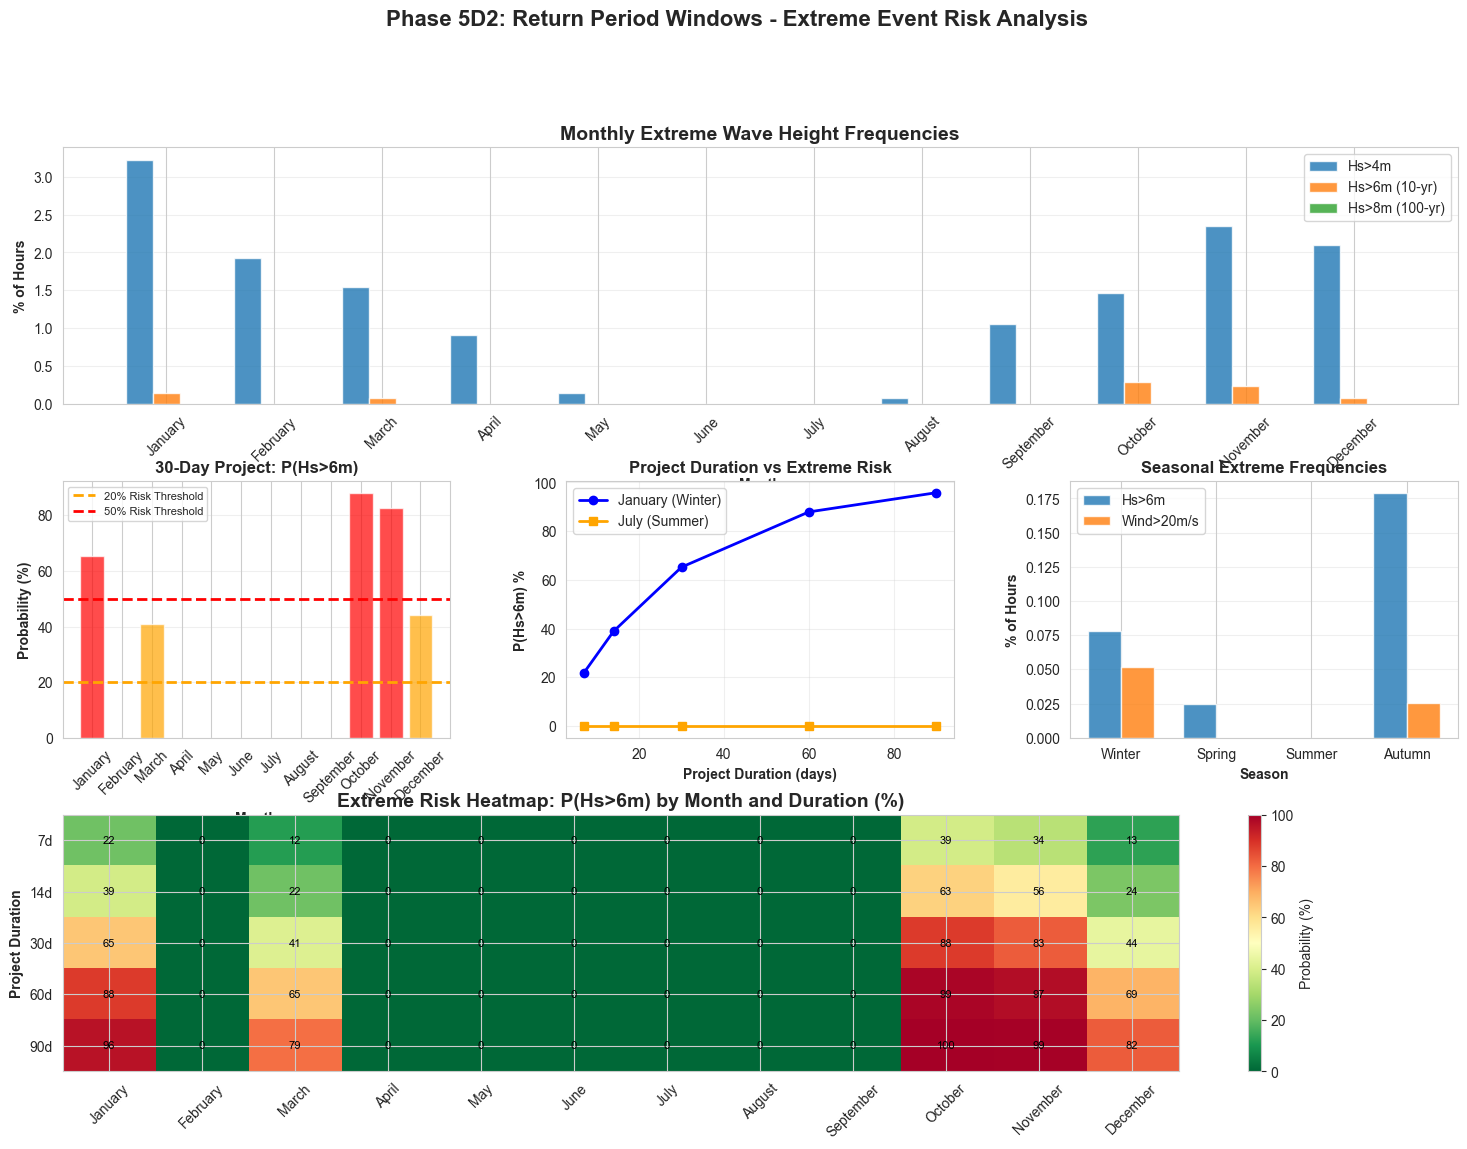

In [7]:
# Cell 7: Comprehensive Visualizations

os.makedirs('../data/processed/phase5d2', exist_ok=True)

fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(3, 3, hspace=0.3, wspace=0.3)

# Plot 1: Monthly extreme frequencies (Hs)
ax1 = fig.add_subplot(gs[0, :])
x = np.arange(12)
width = 0.25

ax1.bar(x - width, df_monthly_extremes['Hs>4.0m']*100, width, label='Hs>4m', alpha=0.8)
ax1.bar(x, df_monthly_extremes['Hs>6.0m']*100, width, label='Hs>6m (10-yr)', alpha=0.8)
ax1.bar(x + width, df_monthly_extremes['Hs>8.0m']*100, width, label='Hs>8m (100-yr)', alpha=0.8)

ax1.set_xlabel('Month', fontweight='bold')
ax1.set_ylabel('% of Hours', fontweight='bold')
ax1.set_title('Monthly Extreme Wave Height Frequencies', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(df_monthly_extremes['Month'], rotation=45)
ax1.legend()
ax1.grid(True, alpha=0.3, axis='y')

# Plot 2: 30-day project risk by month (Hs>6m)
ax2 = fig.add_subplot(gs[1, 0])
colors = ['red' if p > 0.5 else 'orange' if p > 0.2 else 'green' for p in df_project_risk['30d_Hs>6m']]
ax2.bar(df_project_risk['Month'], df_project_risk['30d_Hs>6m']*100, color=colors, alpha=0.7)
ax2.axhline(20, color='orange', linestyle='--', linewidth=2, label='20% Risk Threshold')
ax2.axhline(50, color='red', linestyle='--', linewidth=2, label='50% Risk Threshold')
ax2.set_xlabel('Month', fontweight='bold')
ax2.set_ylabel('Probability (%)', fontweight='bold')
ax2.set_title('30-Day Project: P(Hs>6m)', fontsize=12, fontweight='bold')
ax2.tick_params(axis='x', rotation=45)
ax2.legend(fontsize=8)
ax2.grid(True, alpha=0.3, axis='y')

# Plot 3: Project duration effect (January vs July)
ax3 = fig.add_subplot(gs[1, 1])
jan_data = df_project_risk[df_project_risk['Month']=='January'].iloc[0]
jul_data = df_project_risk[df_project_risk['Month']=='July'].iloc[0]

jan_probs = [jan_data[f'{d}d_Hs>6m']*100 for d in PROJECT_DURATIONS]
jul_probs = [jul_data[f'{d}d_Hs>6m']*100 for d in PROJECT_DURATIONS]

ax3.plot(PROJECT_DURATIONS, jan_probs, marker='o', linewidth=2, label='January (Winter)', color='blue')
ax3.plot(PROJECT_DURATIONS, jul_probs, marker='s', linewidth=2, label='July (Summer)', color='orange')
ax3.set_xlabel('Project Duration (days)', fontweight='bold')
ax3.set_ylabel('P(Hs>6m) %', fontweight='bold')
ax3.set_title('Project Duration vs Extreme Risk', fontsize=12, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

# Plot 4: Seasonal comparison
ax4 = fig.add_subplot(gs[1, 2])
seasons_list = ['Winter', 'Spring', 'Summer', 'Autumn']
hs6_values = [df_seasonal_extremes[df_seasonal_extremes['Season']==s]['Hs>6.0m'].values[0]*100 for s in seasons_list]
wind20_values = [df_seasonal_extremes[df_seasonal_extremes['Season']==s]['Wind>20.0'].values[0]*100 for s in seasons_list]

x_seasons = np.arange(len(seasons_list))
width = 0.35
ax4.bar(x_seasons - width/2, hs6_values, width, label='Hs>6m', alpha=0.8)
ax4.bar(x_seasons + width/2, wind20_values, width, label='Wind>20m/s', alpha=0.8)
ax4.set_xlabel('Season', fontweight='bold')
ax4.set_ylabel('% of Hours', fontweight='bold')
ax4.set_title('Seasonal Extreme Frequencies', fontsize=12, fontweight='bold')
ax4.set_xticks(x_seasons)
ax4.set_xticklabels(seasons_list)
ax4.legend()
ax4.grid(True, alpha=0.3, axis='y')

# Plot 5: Heatmap - 30-day project risk by month
ax5 = fig.add_subplot(gs[2, :])
heatmap_data = []
for days in [7, 14, 30, 60, 90]:
    heatmap_data.append(df_project_risk[f'{days}d_Hs>6m'].values * 100)

im = ax5.imshow(heatmap_data, aspect='auto', cmap='RdYlGn_r', vmin=0, vmax=100)
ax5.set_yticks(range(5))
ax5.set_yticklabels(['7d', '14d', '30d', '60d', '90d'])
ax5.set_xticks(range(12))
ax5.set_xticklabels(df_project_risk['Month'], rotation=45)
ax5.set_ylabel('Project Duration', fontweight='bold')
ax5.set_title('Extreme Risk Heatmap: P(Hs>6m) by Month and Duration (%)', fontsize=14, fontweight='bold')
plt.colorbar(im, ax=ax5, label='Probability (%)')

# Add text annotations
for i, days in enumerate([7, 14, 30, 60, 90]):
    for j in range(12):
        text = ax5.text(j, i, f'{heatmap_data[i][j]:.0f}',
                       ha="center", va="center", color="black", fontsize=8)

plt.suptitle('Phase 5D2: Return Period Windows - Extreme Event Risk Analysis', 
             fontsize=16, fontweight='bold', y=0.995)
plt.savefig('../data/processed/phase5d2/extreme_risk_analysis.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved extreme_risk_analysis.png")
plt.show()

## PART 7: EXTREME-FREE WINDOW IDENTIFICATION

In [8]:
# Cell 8: Identify Optimal Extreme-Free Windows

print("\n[PART 7] Identifying Optimal Extreme-Free Windows...\n")

# Risk tolerance levels
RISK_TOLERANCE = {
    'Low': 0.10,      # 10% risk acceptable
    'Medium': 0.20,   # 20% risk acceptable
    'High': 0.50      # 50% risk acceptable
}

# For 30-day project
project_duration = 30

recommendations = []

for tolerance_name, tolerance_val in RISK_TOLERANCE.items():
    # Find months where risk < tolerance
    suitable_months = df_project_risk[
        df_project_risk[f'{project_duration}d_Hs>6m'] < tolerance_val
    ]['Month'].tolist()
    
    recommendations.append({
        'Risk_Tolerance': tolerance_name,
        'Max_P_Extreme': f"{tolerance_val*100:.0f}%",
        'Suitable_Months': ', '.join(suitable_months) if suitable_months else 'None',
        'n_months': len(suitable_months)
    })

df_recommendations = pd.DataFrame(recommendations)

print("="*80)
print(f"EXTREME-FREE WINDOW RECOMMENDATIONS ({project_duration}-day project)")
print("="*80)
print(df_recommendations.to_string(index=False))

# Best and worst months
best_month = df_project_risk.loc[df_project_risk[f'{project_duration}d_Hs>6m'].idxmin()]
worst_month = df_project_risk.loc[df_project_risk[f'{project_duration}d_Hs>6m'].idxmax()]

print("\n" + "="*80)
print("BEST & WORST MONTHS FOR EXTREME RISK:")
print("="*80)
print(f"\n✅ BEST (Lowest Risk):  {best_month['Month']}")
print(f"   P(Hs>6m in {project_duration}d): {best_month[f'{project_duration}d_Hs>6m']*100:.1f}%")
print(f"\n❌ WORST (Highest Risk): {worst_month['Month']}")
print(f"   P(Hs>6m in {project_duration}d): {worst_month[f'{project_duration}d_Hs>6m']*100:.1f}%")

risk_ratio = worst_month[f'{project_duration}d_Hs>6m'] / best_month[f'{project_duration}d_Hs>6m']
print(f"\n📊 Risk Ratio: {worst_month['Month']} is {risk_ratio:.1f}x riskier than {best_month['Month']}")
print("="*80)


[PART 7] Identifying Optimal Extreme-Free Windows...

EXTREME-FREE WINDOW RECOMMENDATIONS (30-day project)
Risk_Tolerance Max_P_Extreme                                                      Suitable_Months  n_months
           Low           10%                  February, April, May, June, July, August, September         7
        Medium           20%                  February, April, May, June, July, August, September         7
          High           50% February, March, April, May, June, July, August, September, December         9

BEST & WORST MONTHS FOR EXTREME RISK:

✅ BEST (Lowest Risk):  February
   P(Hs>6m in 30d): 0.0%

❌ WORST (Highest Risk): October
   P(Hs>6m in 30d): 87.9%

📊 Risk Ratio: October is infx riskier than February


## PART 8: SAVE RESULTS

In [9]:
# Cell 9: Save Results

results = {
    'return_thresholds': return_thresholds,
    'monthly_extremes': df_monthly_extremes,
    'project_risk': df_project_risk,
    'seasonal_extremes': df_seasonal_extremes,
    'recommendations': df_recommendations,
    'extreme_thresholds': EXTREME_THRESHOLDS,
    'project_durations': PROJECT_DURATIONS
}

with open('../data/processed/phase5d2/extreme_risk_results.pkl', 'wb') as f:
    pickle.dump(results, f)

# Save CSVs
df_monthly_extremes.to_csv('../data/processed/phase5d2/monthly_extreme_frequencies.csv', index=False)
df_project_risk.to_csv('../data/processed/phase5d2/project_extreme_risk.csv', index=False)
df_seasonal_extremes.to_csv('../data/processed/phase5d2/seasonal_extreme_comparison.csv', index=False)

print("\n✅ Results saved to: data/processed/phase5d2/")


✅ Results saved to: data/processed/phase5d2/


## PART 9: KEY FINDINGS & INTEGRATION WITH PHASE 5D1

In [10]:
# Cell 10: Summary & Integration

print("\n" + "="*80)
print("PHASE 5D2 COMPLETE: KEY FINDINGS")
print("="*80)

print("\n1. EXTREME EVENT RISK BY SEASON:")
for season in ['Winter', 'Spring', 'Summer', 'Autumn']:
    freq = df_seasonal_extremes[df_seasonal_extremes['Season']==season]['Hs>6.0m'].values[0]
    print(f"   {season:8s}: {freq*100:.2f}% of hours exceed Hs>6m")

print("\n2. PROJECT DURATION IMPACT (30-day project):")
print(f"   Best month:  {best_month['Month']} ({best_month['30d_Hs>6m']*100:.1f}% risk)")
print(f"   Worst month: {worst_month['Month']} ({worst_month['30d_Hs>6m']*100:.1f}% risk)")
print(f"   Risk multiplier: {risk_ratio:.1f}x")

print("\n3. RECOMMENDED MONTHS (30-day project):")
low_risk_months = df_project_risk[df_project_risk['30d_Hs>6m'] < 0.10]['Month'].tolist()
if low_risk_months:
    print(f"   Low Risk (<10%): {', '.join(low_risk_months)}")
else:
    print("   Low Risk (<10%): None")

med_risk_months = df_project_risk[
    (df_project_risk['30d_Hs>6m'] >= 0.10) & (df_project_risk['30d_Hs>6m'] < 0.20)
]['Month'].tolist()
if med_risk_months:
    print(f"   Medium Risk (10-20%): {', '.join(med_risk_months)}")

high_risk_months = df_project_risk[df_project_risk['30d_Hs>6m'] >= 0.20]['Month'].tolist()
if high_risk_months:
    print(f"   High Risk (>20%): {', '.join(high_risk_months)}")

print("\n4. INTEGRATION WITH PHASE 5D1:")
print("   Phase 5D1: Workability (can I work?)")
print("   Phase 5D2: Extreme Risk (am I safe?)")
print("\n   COMBINED RECOMMENDATION:")

# Load Phase 5D1 results for comparison
try:
    with open('../data/processed/phase5d1/weather_window_results.pkl', 'rb') as f:
        phase5d1_results = pickle.load(f)
    
    # Find optimal month: high workability + low extreme risk
    best_combined = None
    best_score = -1
    
    for month in df_project_risk['Month']:
        # Workability from 5D1 (5-day window probability)
        workability = phase5d1_results['continuous_window_probabilities'][
            phase5d1_results['continuous_window_probabilities']['Month'] == month
        ]['5d_Copula'].values[0]
        
        # Extreme risk from 5D2
        extreme_risk = df_project_risk[
            df_project_risk['Month'] == month
        ]['30d_Hs>6m'].values[0]
        
        # Combined score (high workability, low risk)
        score = workability * (1 - extreme_risk)
        
        if score > best_score:
            best_score = score
            best_combined = (month, workability, extreme_risk)
    
    if best_combined:
        month, work, risk = best_combined
        print(f"\n   🎯 OPTIMAL MONTH: {month}")
        print(f"      5-day workability: {work*100:.1f}%")
        print(f"      30-day extreme risk: {risk*100:.1f}%")
        print(f"      Combined score: {best_score:.3f}")
        
except FileNotFoundError:
    print("   (Phase 5D1 results not found - run Phase 5D1 first for integration)")

print("\n" + "="*80)
print("⚠️  CRITICAL REMINDER:")
print("   - These results are LOCATION-SPECIFIC (UK Northeast Coast)")
print("   - Different sites will have different extreme patterns")
print("   - Re-analysis required for other locations")
print("="*80)

print("\n" + "="*80)
print("Next: Phase 5D3 - Operational Window Forecasting")
print("Question: Can we predict N-day weather windows from historical patterns?")
print("="*80)


PHASE 5D2 COMPLETE: KEY FINDINGS

1. EXTREME EVENT RISK BY SEASON:
   Winter  : 0.08% of hours exceed Hs>6m
   Spring  : 0.02% of hours exceed Hs>6m
   Summer  : 0.00% of hours exceed Hs>6m
   Autumn  : 0.18% of hours exceed Hs>6m

2. PROJECT DURATION IMPACT (30-day project):
   Best month:  February (0.0% risk)
   Worst month: October (87.9% risk)
   Risk multiplier: infx

3. RECOMMENDED MONTHS (30-day project):
   Low Risk (<10%): February, April, May, June, July, August, September
   High Risk (>20%): January, March, October, November, December

4. INTEGRATION WITH PHASE 5D1:
   Phase 5D1: Workability (can I work?)
   Phase 5D2: Extreme Risk (am I safe?)

   COMBINED RECOMMENDATION:

   🎯 OPTIMAL MONTH: July
      5-day workability: 41.2%
      30-day extreme risk: 0.0%
      Combined score: 0.412

⚠️  CRITICAL REMINDER:
   - These results are LOCATION-SPECIFIC (UK Northeast Coast)
   - Different sites will have different extreme patterns
   - Re-analysis required for other locatio